In [ ]:
!python -m spacy download en_core_web_lg

2022-11-06 06:14:53.714707: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 15 kB/s 


In [ ]:
from google.colab import widgets
import ipywidgets as widgets
from IPython.display import display, clear_output, Image
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.spatial import distance
import re
import tensorflow as tf
import spacy

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_lg')

def clean(text):
    sample = np.array(re.split(r'(\. )|(\n)', text))
    sample = sample[sample != np.array(None)]
    cleansample = np.array([i for i in sample if len(i) > 6])
    return cleansample

def attrSep(proc: spacy.tokens.doc.Doc) -> list:
    info = proc.similarity(nlp('information facts assertion'))
    pers = proc.similarity(nlp('imperative persuasive argument'))
    desc = proc.similarity(nlp('descriptive demonstration workshop'))
    entr = proc.similarity(nlp('entertaining witty engaging'))
    cerm = proc.similarity(nlp('occasion ceremony tribute'))
    return [info, pers, desc, entr, cerm]

def NearestNeighbour(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    return closest_index

def analyse(data: list) -> list:
    reslist = []
    matchData = pd.read_csv('/content/drive/MyDrive/defdata.csv')
    maxd = matchData.max().tolist()
    mind = matchData.min().tolist()

    for i in range(len(data)):
        cleansample = clean(str(data[i]))
        rawspeech = " ".join(cleansample.tolist())
        proc = nlp(rawspeech)
        attrList = attrSep(proc)
        scaledattr = [max(0.01, ((attrList[x] - mind[x+3])/(maxd[x+3] - mind[x+3]))) for x in range(5)]
        close = NearestNeighbour(attrList, matchData.loc[:, 'informative':'ceremonial'])
        reslist.append(scaledattr + matchData.loc[close, 'title':'classification'].tolist())


    return reslist
analyse(["hello hi wassup"])

FileNotFoundError: ignored

In [ ]:
started = widgets.Button(
    description='Get Started',
    disabled=False,
    layout=widgets.Layout(width='50%', height='50px'),
    tooltip='Get Started',
)

analyse_b = widgets.Button(
    description='Analyse your speech',
    disabled=False,
    layout=widgets.Layout(width='50%', height='50px'),
    tooltip='Analyse your speech',
    style=dict(
    font_weight='bold',
    button_color = 'blue'
)
)
uploader = widgets.FileUpload(layout=widgets.Layout(width='50%', height='50px'), multiple=True)

categories=['Information', 'Persuasion', 'Description', 'Entertainement', 'Ceremony']
fig = go.Figure()

def on_button_started(b):
  started.close()
  text = widgets.HTML(
    value="<h1>Upload files to be analysed</h1><br>",
  )
  text_box = widgets.GridBox([widgets.Label(), text], layout=widgets.Layout(grid_template_columns="repeat(3, 450px)"))
  display(text_box)
  up_box = widgets.GridBox([widgets.Label(), uploader], layout=widgets.Layout(grid_template_columns="repeat(3, 500px)"))
  display(up_box)
  analyse_box = widgets.GridBox([widgets.Label(), analyse_b], layout=widgets.Layout(grid_template_columns="repeat(3, 500px)"))
  display(analyse_box)

def on_button_analyse(b):
  clear_output()
  texts = []
  keys = list(uploader.value.keys())
  for i in range(0, len(uploader.value)):
    texts.append(uploader.value[keys[i]]['content'].decode("utf-8"))
  score_list = analyse(texts)
  for i in range(0, len(score_list)):
    temp_score = []
    temp_score = score_list[i][0:5]
    for j in range(0,5):
      temp_score[j] = temp_score[j] * 5
    fig.add_trace(go.Scatterpolar(r=temp_score, theta=categories, fill='toself', name='Speech' + str(i + 1)))
  fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 5])),showlegend=True, template="plotly_dark")
  fig.show()
  for i in range(0, len(score_list)):
    temp_box = widgets.HTML( value=str("<br><h1>" + "Speech " + str(i+1) + " is most similar to '" + str(score_list[i][5]) + "' by " + str(score_list[i][6]) + " with a " + str(score_list[i][7]) +" tone."+ "</h1>"))
    display(temp_box)
analyse_b.on_click(on_button_analyse)
def start():
  items = [widgets.Label(), started]
  x = widgets.GridBox([widgets.Label(), started], layout=widgets.Layout(grid_template_columns="repeat(3, 500px)"))
  display(x)
  started.on_click(on_button_started)

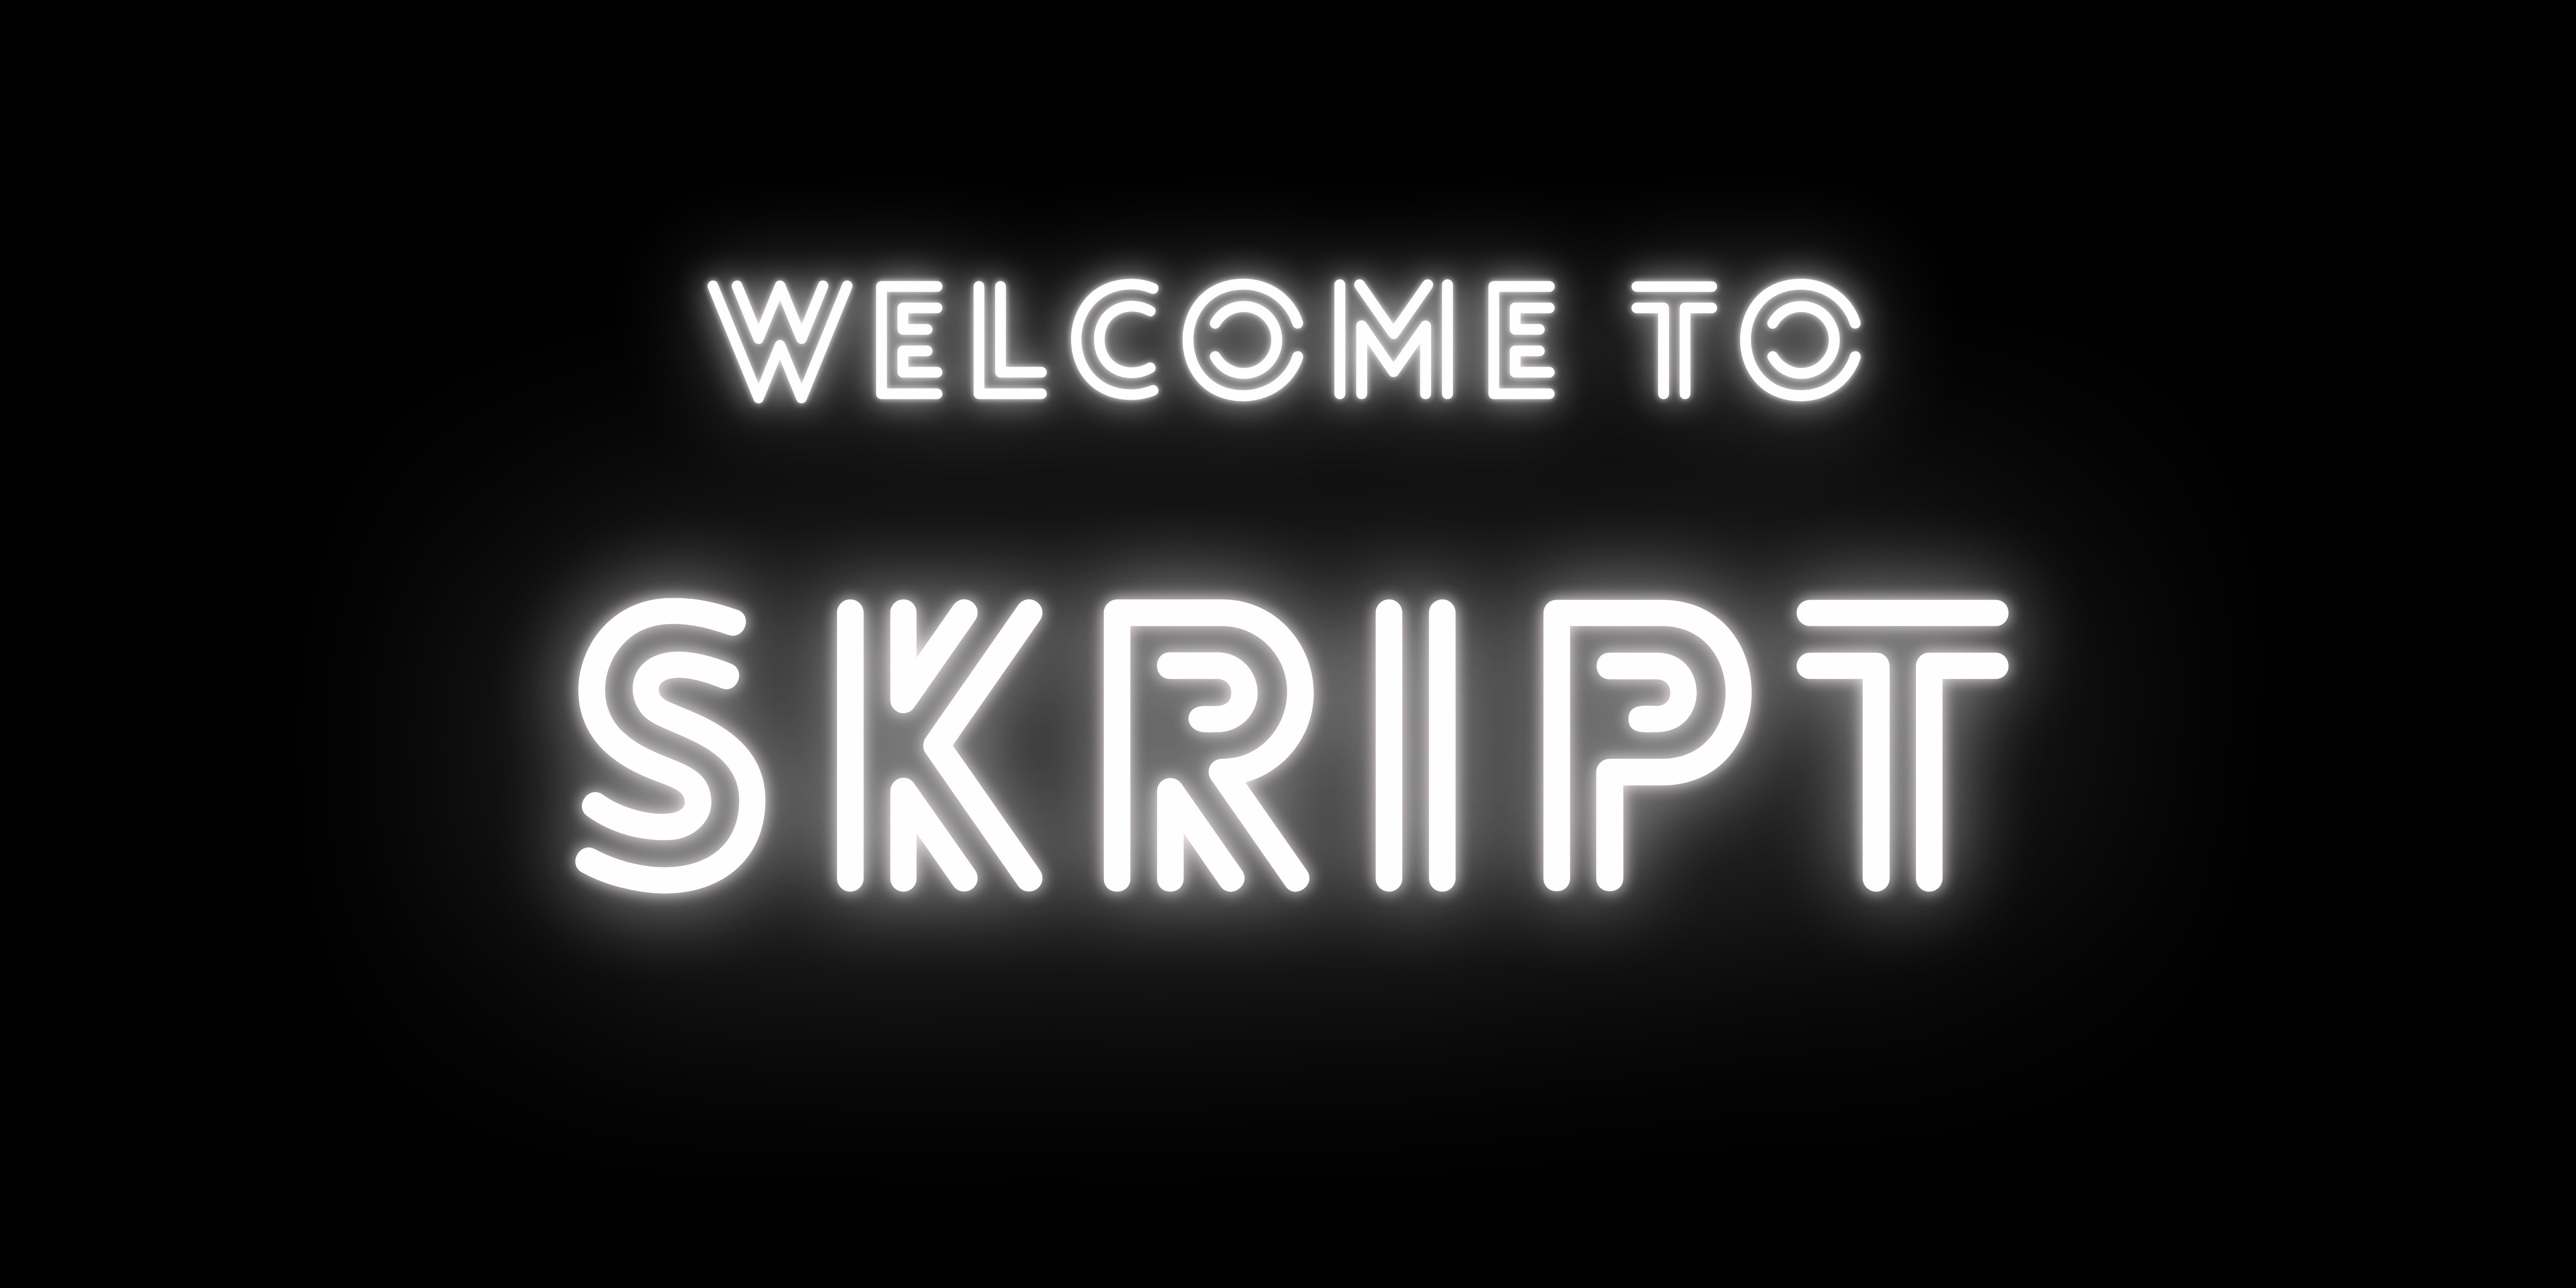

In [ ]:
start()